# Self-consistent solution of $\kappa-sech^2$-type electron hole

In [408]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

In [409]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [410]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 100


vmax = 100 # 速度最大值
nx = 1000
nv = 10000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

## sech2分布
$$ f_u(w>0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left[ 1 + \frac{(\pm \sqrt{2w}+u)^2}{\kappa\theta^2} \right]^{-\kappa} $$
$$ N_\kappa = \frac{n_\infty \Gamma(\kappa)}{\Gamma(\kappa-1/2)} $$
$$ f_t(w<0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left( 1 - \frac{u^2}{\kappa\theta^2} \right)^{-\kappa} 
              \left[ 1-W \frac{2\kappa}{\kappa \theta^2 + u^2} 
                      \left(   1-\frac{2(\kappa+1)u^2}{\kappa\theta^2+u^2}  \right)
              \right]$$
其中$w=v^2/2-\phi$
## 理论自洽解
$$ \phi = \psi sech^2 \left(\frac{\sqrt{B_s}x}{2}\right) $$
$$ B_s = \frac{2n_\infty}{\theta^2} \left[ 1 -\frac{1}{2\kappa} + \frac{u}{\theta} Z_\kappa\left(\frac{u}{\theta}\right) \right] $$
$$ D_s = \frac{n_\infty (\kappa+1/2)(\kappa-1/2)}{\theta^4 \kappa^2 (\kappa+2)} 
            \left\{ _2F_1\left[2,2\kappa+3;\kappa+3;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            + i \frac{\kappa+3/2}{\sqrt{\kappa}(\kappa+3)}\frac{u}{\theta} {}_2F_1\left[3,2\kappa+4;\kappa+4;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            \right\}$$
$$ \theta = \sqrt{ \frac{\kappa-3/2}{\kappa} \frac{2T}{m} } $$

In [419]:
import mpmath as mp
mp.dps=10
# para_in = 'theta'
para_in = 'T'

def Un_nonvec(u,kappa,n):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac1= (1j/2)**(n+1)
    fac2= np.math.factorial(n)*sp.gamma(2*kappa+n)*sp.gamma(kappa+1)/kappa**(1.5+n/2)/sp.gamma(2*kappa-1)/sp.gamma(kappa+1+n)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1+n,2*kappa+n,kappa+1+n,z))
    return (fac1*fac2*hyp).real

def B_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = (kappa-0.5) / kappa / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(2,2*kappa+1,kappa+2,z))
    return 1.0/theta**2*fac*hyp.real

def D_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 1.5 * (kappa-0.5) * (kappa+0.5) / kappa**2 / (kappa+2.0) / (kappa+3.0) / theta**4
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(4,2*kappa+3,kappa+4,z))
    return fac*hyp.real

def E_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 32.0*np.sqrt(2)/45.0 * sp.gamma(kappa)/sp.gamma(kappa-0.5)/np.sqrt(kappa*np.pi)/theta
    es1 = (1+zeta**2/kappa)**(-kappa-4)*(kappa+1)/kappa**3/theta**4
    es2 = (2*kappa+3)*(2*kappa+1)*zeta**4 - 6*kappa*(2*kappa+3)*zeta**2 + 3*kappa**2
    return -fac*es1*es2

def F_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 5.0*sp.gamma(2*kappa+5)*sp.gamma(kappa+1)/128.0/kappa**4/sp.gamma(2*kappa-1)/sp.gamma(kappa+6)/theta**6
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(6,2*kappa+5,kappa+6,z))
    return fac*hyp.real

def B_M_nonvec(u):
    r = 1.0+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
    return r

def D_M_nonvec(u):
    r = ( (3.0-u**2)*B_M_nonvec(u)-1.0 )/4.0
    return r

def E_M_nonvec(u):
    r = -8.0/45.0/np.sqrt(np.pi)*np.exp(-u**2/2)*(u**4-6*u**2+3)
    return r

def F_M_nonvec(u):
    theta = np.sqrt(2)
    xi = u/theta
    Z = plasmapy.dispersion.plasma_dispersion_func(xi).real
    Z1 = -2*(1+xi*Z)
    Z2 = -2*(Z+xi*Z1)
    Z3 = -2*(2*Z1+xi*Z2)
    Z4 = -2*(3*Z2+xi*Z3)
    Z5 = -2*(4*Z3+xi*Z4)
    r = -Z5/384.0
    return r

Un = np.vectorize(Un_nonvec)
B_kappa = np.vectorize(B_kappa_nonvec)
D_kappa = np.vectorize(D_kappa_nonvec)
E_kappa = np.vectorize(E_kappa_nonvec)
F_kappa = np.vectorize(F_kappa_nonvec)

B_M = np.vectorize(B_M_nonvec)
D_M = np.vectorize(D_M_nonvec)
E_M = np.vectorize(E_M_nonvec)
F_M = np.vectorize(F_M_nonvec)

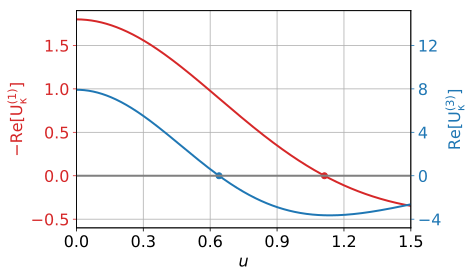

In [420]:
kappa = 5
theta = np.sqrt(2.0-3.0/kappa)
    
u = np.linspace(0.,2.0,num=800)
U1 = -Un(u,kappa,1)
U3 = Un(u,kappa,3)
U1zero = op.root(lambda x:Un(x,kappa,1),theta/np.sqrt(2.0)).x[0]
U3zero = op.root(lambda x:Un(x,kappa,3),theta/np.sqrt(2.0)).x[0]
ur =(np.sqrt(0.5) - Un(theta/np.sqrt(2.0),kappa,1)/Un(theta/np.sqrt(2.0),kappa,2))*theta
ul =(np.sqrt(0.5) - Un(theta/np.sqrt(2.0),kappa,3)/Un(theta/np.sqrt(2.0),kappa,4))*theta

ax1_yticks = [-0.5,0  ,0.5,1.0,1.5]
ax2_yticks = [-4  ,0  ,4  ,8  ,12]
xticks = [0.0,0.3,0.6,0.9,1.2,1.5]

fig = plt.figure(figsize=(6,4))
ax1 = fig.gca()

ax1.plot(u,U1,label='B',color='tab:red')
ax1.scatter(U1zero,0.0,marker='o',color='tab:red')
ax1.set_xlabel(r'$u$')
ax1.set_ylabel(r'$-\rm{Re}[U^{(1)}_\kappa]$',color='tab:red')
ax1.set_xticks(xticks)
ax1.set_yticks(ax1_yticks)
ax1.tick_params(axis='y', colors='tab:red')
ax1.set_xlim(0.,1.5)
ax1.set_ylim(-0.6,1.9)
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(u,U3,label='D',color='tab:blue')
ax2.scatter(U3zero,0.0,marker='o',color='tab:blue')
ax2.set_ylabel(r'$\rm{Re}[U^{(3)}_\kappa]$',color='tab:blue')
ax2.set_xticks(xticks)
ax2.set_yticks(ax2_yticks)
ax2.tick_params(axis='y', colors='tab:blue')
ax2.set_xlim(0.,1.5)
ax2.set_ylim(-4.8,15.2)

# plt.axvline(U3zero,linestyle=':',color='tab:blue')
# plt.axvline(U1zero,linestyle=':',color='tab:red')
plt.axhline(0,linestyle='-',color='gray')
# plt.savefig('../0-origin/fig1.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

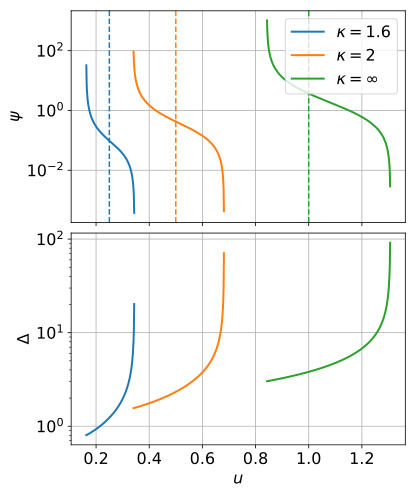

In [384]:
u = np.linspace(0.,1.42,num=1200)
kappa1 = 1.6
kappa2 = 2
psi1 = -3.0*B_kappa(u,kappa1)/D_kappa(u,kappa1)/2.0
psi2 = -3.0*B_kappa(u,kappa2)/D_kappa(u,kappa2)/2.0
psi3 = -3.0*B_M(u)/D_M(u)/2.0
Bk1 = B_kappa(u,kappa1)
psi1[psi1<0] = np.nan
psi1[Bk1<0] = np.nan
psi2[psi2<0] = np.nan
psi3[psi3<0] = np.nan

delta1 = 2.0/np.sqrt(B_kappa(u[psi1>=0],kappa1))
delta2 = 2.0/np.sqrt(B_kappa(u[psi2>=0],kappa2))
delta3 = 2.0/np.sqrt(B_M(u[psi3>=0]))

theta1 = np.sqrt(2.0-3.0/kappa1)/np.sqrt(2)
theta2 = np.sqrt(2.0-3.0/kappa2)/np.sqrt(2)
theta3 = np.sqrt(2.0)/np.sqrt(2)

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax1.plot(u,psi1,label=r'$\kappa=1.6$',color='tab:blue')
ax1.plot(u,psi2,label=r'$\kappa=2$',color='tab:orange')
ax1.plot(u,psi3,label=r'$\kappa=\infty$',color='tab:green')
ax1.axvline(theta1,linestyle='--',linewidth=1.5,color='tab:blue')
ax1.axvline(theta2,linestyle='--',linewidth=1.5,color='tab:orange')
ax1.axvline(theta3,linestyle='--',linewidth=1.5,color='tab:green')

ax1.set_yscale('log')
ax1.set_ylabel(r'$\psi$')
ax1.grid()
ax1.legend(loc=1)
# ax1.set_ylim(0.005,500)
plt.xticks([0.2,0.4,0.6,0.8,1.0,1.2],())

ax2 = plt.subplot(212)
ax2.plot(u[psi1>=0],delta1,label=r'$\kappa=1.6$')
ax2.plot(u[psi2>=0],delta2,label=r'$\kappa=2$')
ax2.plot(u[psi3>=0],delta3,label=r'$\kappa=\infty$')

ax2.set_xlabel(r'$u$')
ax2.set_ylabel(r'$\Delta$')
ax2.set_xticks([0.2,0.4,0.6,0.8,1.0,1.2])
ax2.set_yscale('log')
ax2.grid()
# ax2.legend(loc=3)
plt.subplots_adjust(hspace = 0.05,wspace=0.26)
# plt.savefig('../0-origin/fig2.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

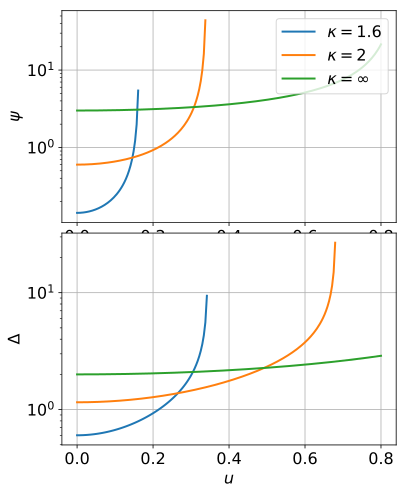

In [403]:
u = np.linspace(0.,0.8,num=200)
kappa1 = 1.6
kappa2 = 2
psi1 = -3.0*B_kappa(u,kappa1)/D_kappa(u,kappa1)/2.0
psi2 = -3.0*B_kappa(u,kappa2)/D_kappa(u,kappa2)/2.0
psi3 = -3.0*B_M(u)/D_M(u)/2.0
Bk1 = B_kappa(u,kappa1)
Bk2 = B_kappa(u,kappa2)
Bk3 = B_M(u)
psi1[Bk1<0] = np.nan
psi2[Bk2<0] = np.nan
psi3[Bk3<0] = np.nan
psi1[psi1>0] = np.nan
psi2[psi2>0] = np.nan
psi3[psi3>0] = np.nan

delta1 = 2.0/np.sqrt(B_kappa(u[Bk1>0],kappa1))
delta2 = 2.0/np.sqrt(B_kappa(u[Bk2>0],kappa2))
delta3 = 2.0/np.sqrt(B_M(u[Bk3>0]))

theta1 = np.sqrt(2.0-3.0/kappa1)/np.sqrt(2)
theta2 = np.sqrt(2.0-3.0/kappa2)/np.sqrt(2)
theta3 = np.sqrt(2.0)/np.sqrt(2)

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax1.plot(u,-psi1,label=r'$\kappa=1.6$',color='tab:blue')
ax1.plot(u,-psi2,label=r'$\kappa=2$',color='tab:orange')
ax1.plot(u,-psi3,label=r'$\kappa=\infty$',color='tab:green')

ax1.set_yscale('log')
ax1.set_ylabel(r'$\psi$')
ax1.grid()
ax1.legend(loc=1)
# ax1.set_ylim(0.005,500)
# plt.xticks([0.2,0.4,0.6,0.8,1.0,1.2],())

ax2 = plt.subplot(212)
ax2.plot(u[Bk1>0],delta1,label=r'$\kappa=1.6$')
ax2.plot(u[Bk2>0],delta2,label=r'$\kappa=2$')
ax2.plot(u[Bk3>0],delta3,label=r'$\kappa=\infty$')

ax2.set_xlabel(r'$u$')
ax2.set_ylabel(r'$\Delta$')
# ax2.set_xticks([0.2,0.4,0.6,0.8,1.0,1.2])
ax2.set_yscale('log')
ax2.grid()
# ax2.legend(loc=3)
plt.subplots_adjust(hspace = 0.05,wspace=0.26)
# plt.savefig('../0-origin/fig2.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [421]:
u = 0.6
kappa = 2

if para_in == 'theta':
    theta = np.sqrt(2)
elif para_in == 'T':
    theta = np.sqrt(2.0-3.0/kappa)
    
psi =-3.0*B_kappa(u,kappa)/D_kappa(u,kappa)/2.0 
delta = 2.0/np.sqrt(B_kappa(u,kappa))
print('delta',delta)
print('psi',psi)

delta 3.7634563374116063
psi 0.14267637738366626


In [422]:
B = B_kappa(u,kappa)
D = D_kappa(u,kappa)
E = E_kappa(u,kappa)
F = F_kappa(u,kappa)

In [423]:
def psieq(p):
    return B/2.0 + D/3.0 * p + 2.0/7.0*E*p**(1.5) + F/4 * p**2

In [424]:
sol = op.root(psieq,psi)
psi_new = sol.x[0]
print(sol.success,psi_new)

True 0.2162643088105424


In [425]:
xp = (x-L/2)/delta
phi = 1.0*psi_new*np.cosh(xp)**(-2)
c1 = phi[0]
c2 = phi[-1]
# c1 = 0.0
# c2 = 0.0

In [426]:
@nb.jit
def nonvec_f_fun_sech2(v,phi):
    r = 0
    v_waveframe = v
    w = (v_waveframe**2)/2-phi
    kt2 = kappa*theta**2
    fac = math.gamma(kappa)/math.gamma(kappa-0.5)/math.sqrt(math.pi*kt2)
    if w>0:
        if v_waveframe<=-math.sqrt(2*phi):
            r=(1+(-(2*w)**0.5+u)**2/kt2)**(-kappa)
        elif v_waveframe>math.sqrt(2*phi):
            r=(1+( (2*w)**0.5+u)**2/kt2)**(-kappa)
    else:
        r=(1+u**2/kt2)**(-kappa) * (1-w * (2*kappa/(kt2+u**2)) * (1-2*(kappa+1)*u**2/(kt2+u**2)) )
    return fac*r
f_fun_sech2 = np.vectorize(nonvec_f_fun_sech2)

In [427]:
for count in tqdm(range(10)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun_sech2(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    
    # Dirichlet BC phi[0]=c1 phi[-1]=c2
    r[0]  += c1
    r[-1] += c2
    
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    if err<= 1e-6:
        print("Sucess! Iteration counts =", count)
        break
print(err)

 30%|█████████████████▋                                         | 3/10 [00:11<00:27,  3.89s/it]

Sucess! Iteration counts = 3
3.0690082542845666e-08


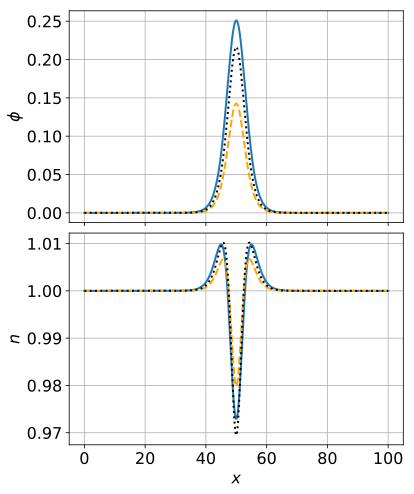

In [428]:
phi_theo = psi*np.cosh((x-L/2)/delta)**(-2)
phi_theo_new = psi_new*np.cosh((x-L/2)/delta)**(-2)
n_theo = 1+(4*phi_theo - 6*phi_theo**2/psi)/delta**2
n_theo_new = 1+(4*phi_theo_new - 6*phi_theo_new**2/psi_new)/delta**2
xticks = np.linspace(0,L,num=6)

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(212)
ax1.plot(x,n_vector)
ax1.plot(x,n_theo,color='orange',linestyle='--')
ax1.plot(x,n_theo_new,color='black',linestyle=':')
ax1.grid()
plt.xticks(xticks)
ax1.set_ylabel(r'$n$')

ax3 = plt.subplot(211)
ax3.plot(x,phi,label=r'numerical')
ax3.plot(x,phi_theo,color='orange',linestyle='--',label=r'analytic')
ax3.plot(x,phi_theo_new,color='black',linestyle=':',label=r'$\psi_m$')
ax3.grid()
plt.xticks(xticks,())
ax1.set_xlabel(r'$x$')
ax3.set_ylabel(r'$\phi$')
# ax3.legend()
# ax3.set_xlim(0.3*L,0.7*L)
# ax3.set_yscale('log')
plt.subplots_adjust(hspace = 0.05,wspace=0.26)
# plt.savefig('../0-origin/fig3.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [376]:
# V,Phi=np.meshgrid(v,phi)
# f_matrix = f_fun_sech2(V,Phi)
# fv = f_matrix.sum(axis=0)*dx/L
# plt.plot(v,f_matrix[int(nx/2),])
# plt.xlim(-5*theta,5*theta)
# # plt.ylim(0.05,0.31)
# plt.grid()

In [377]:
def phi4_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-4)

def phi2_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-2)

from scipy.optimize import curve_fit
para4,pcov=curve_fit(phi4_theo,x,phi)
para2,pcov=curve_fit(phi2_theo,x,phi)
Ddelta = round(abs(para2[1]-delta)/para2[1]*100,2)
Dpsi = round(abs(para2[0]-psi)/para2[0]*100,2)  

# Dpsi_new = round(abs(phi.max()-psi_new)/phi.max()*100,2)  
Dpsi_new = round(abs(para2[0]-psi_new)/para2[0]*100,2)  

print('sech4 fit:',para4)
print('sech2 fit:',para2)
print('Dpsi     :',Dpsi,'%')
print('Ddelta   :',Ddelta,'%')
print('Dpsi_new:',Dpsi_new,'%')

sech4 fit: [0.76505274 9.52767538]
sech2 fit: [0.77552123 6.35774385]
Dpsi     : 45.72 %
Ddelta   : 9.96 %
Dpsi_new: 20.71 %


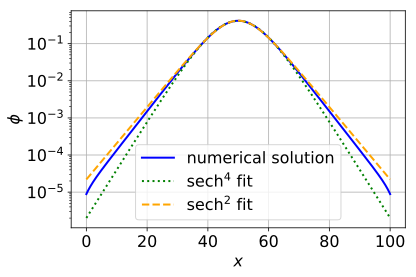

In [362]:
fig = plt.figure(figsize=(6,4))
plt.plot(x,phi,color='blue',label=r'numerical solution')
plt.plot(x,phi4_theo(x,para4[0],para4[1]),':',color='green',label=r'$\mathrm{sech}^4$ fit')
plt.plot(x,phi2_theo(x,para2[0],para2[1]),'--',color='orange',label=r'$\mathrm{sech}^2$ fit')
# plt.plot(x,phi2_theo(x,psi,delta),'--',color='green')
# plt.xlim(0.3*L,0.7*L)
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi$')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [325]:
# mat.append([u,round(para2[1],3),round(delta,3),Ddelta,round(para2[0],3),round(psi,3),round(psi_new,3),Dpsi,Dpsi_new])

In [326]:
table = PrettyTable(['u','delta_sc','delta_th','delta_err(%)','psi_sc','psi_th','psi_th_new','psi_err(%)','psi_new_err(%)'])
for i in range(len(mat)):
    table.add_row(mat[i])
print('kappa=',kappa)
print(table)

kappa= 2
+------+----------+----------+--------------+--------+--------+------------+------------+----------------+
|  u   | delta_sc | delta_th | delta_err(%) | psi_sc | psi_th | psi_th_new | psi_err(%) | psi_new_err(%) |
+------+----------+----------+--------------+--------+--------+------------+------------+----------------+
| 0.6  |  4.157   |  3.763   |     9.47     | 0.253  | 0.143  |   0.216    |    43.6    |     14.52      |
| 0.61 |  4.434   |  4.053   |     8.59     | 0.206  | 0.123  |   0.185    |   40.22    |      10.3      |
| 0.62 |  4.778   |   4.41   |     7.71     | 0.165  | 0.104  |   0.154    |   36.74    |      6.92      |
| 0.63 |  5.219   |  4.863   |     6.83     | 0.129  | 0.086  |   0.123    |   33.11    |      4.36      |
| 0.64 |  5.813   |  5.469   |     5.93     | 0.097  | 0.069  |   0.095    |   29.28    |      2.57      |
| 0.65 |  6.673   |  6.339   |     5.0      | 0.069  | 0.051  |   0.068    |   25.13    |      1.39      |
| 0.66 |  8.082   |  7.758  

In [232]:
# mat = []

In [594]:
# mat = mat[0:-2]

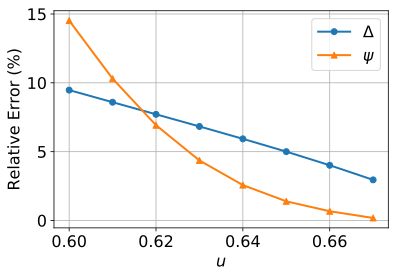

In [379]:
mat_np = np.array(mat)
u_list = mat_np[:,0]
delta_nu_list = mat_np[:,1]
delta_th_list = mat_np[:,2]
psi_nu_list = mat_np[:,4]
psi_th_list = mat_np[:,6]
delta_err_list = mat_np[:,3]
psi_err_list = mat_np[:,-1]

fig = plt.figure(figsize=(6,4))
plt.plot(u_list,delta_err_list,marker='o',label=r'$\Delta$')
plt.plot(u_list,psi_err_list,marker='^',label=r'$\psi$')

# plt.plot(u_list,psi_th_list)
# plt.plot(u_list,psi_nu_list)
# plt.plot(u_list,delta_th_list)
# plt.plot(u_list,delta_nu_list)

plt.ylabel('Relative Error (%)')
plt.xlabel(r'$u$')
plt.legend()
plt.grid()
# plt.savefig('../0-origin/fig4.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [338]:
psi_last = psi 
psi_next = psi_last - (2*E/7*(psi_last)**1.5+F/4*(psi_last)**2) / (D/3+3*E/7*(psi_last)**0.5+F/2*psi_last)
# psi_next = psi_last - (F/4*(psi_last)**2) / (D/3+F/2*psi_last)
# psi_next = psi_last - (2*E/7*(psi_last)**1.5) / (D/3+3*E/7*(psi_last)**0.5)
print(psi)
print(psi_next)
print(psi_new)
print(para2[0])

0.05148741458715211
0.06746359309871822
0.0678111700068698
0.06876573644272974


In [339]:
abs(psi_next-para2[0])/para2[0]*100

1.8935932506096043

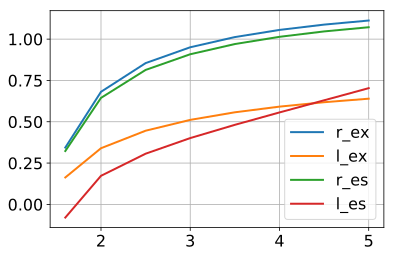

In [271]:
kappa_list = [1.6,2,2.5,3.0,3.5,4.0,4.5,5.0]
delU_ex_list = []
delU_es_list = []
U1zero_list = []
U3zero_list = []
Ur_list = []
Ul_list = []
for kp in kappa_list:
    theta = np.sqrt(2.0-3.0/kp)
    U1zero = op.root(lambda x:Un(x,kp,1),theta/np.sqrt(2.0)).x[0]
    U3zero = op.root(lambda x:Un(x,kp,3),theta/np.sqrt(2.0)).x[0]
    Ur = theta/np.sqrt(2.0)
    Ul = theta/np.sqrt(2.0)
    for n in range(1):
        Ur = Ur - Un(Ur,kp,1)/Un(Ur,kp,2)*theta
#         Ul =Ul - Un(Ul,kp,3)/Un(Ul,kp,4)*theta
#         Ul =Ul - Un(Ul,kp,4)/Un(Ul,kp,5)*theta - np.sqrt(Un(Ul,kp,4)/Un(Ul,kp,5)**2-2*Un(Ul,kp,3)/Un(Ul,kp,5))*theta
        Ul = Ul - Un(Ul,kp,3)/Un(Ul,kp,4)*theta - Un(Ul,kappa,5)*Un(Ul,kappa,3)**2/Un(Ul,kappa,4)**3/2*theta
    delU_ex_list.append(U1zero-U3zero)
    delU_es_list.append(Ur-Ul)
    Ur_list.append(Ur)
    Ul_list.append(Ul)
    U1zero_list.append(U1zero)
    U3zero_list.append(U3zero)

# plt.plot(kappa_list,delU_ex_list)
# plt.plot(kappa_list,delU_es_list)
plt.plot(kappa_list,U1zero_list,label='r_ex')
plt.plot(kappa_list,U3zero_list,label='l_ex')
plt.plot(kappa_list,Ur_list,label='r_es')
plt.plot(kappa_list,Ul_list,label='l_es')
plt.grid()
plt.legend()
plt.show()